# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from tabulate import tabulate

# Configs

In [2]:
BASE_PATH = "/Users/maedeh/Desktop/demand_project/demand_project/shoofer-demand-prediction/data/"

LABELED_PATH = BASE_PATH + "labels_phase1.parquet"
XGB_MODEL_PATH = BASE_PATH + "XGB_predictions_phase1.parquet"
REGRESSION_MODEL_PATH = BASE_PATH + "Ridge_predictions_phase1.parquet"
# RF_MODEL_PATH = BASE_PATH + "RF_predictions_phase1.parquet"

SAVE_PLOT_PATH = BASE_PATH + 'pngs/'

MODEL_LIST = ['BASELINE_LAST_WEEK', 'REGRESSION_MODEL', 'XGB_MODEL']
CATEGORIES = ['high_demand_locations', 'mid_demand_locations', 'low_demand_locations', 'all_locations']
METRICS = ['MAPE', 'MAE', 'RMSE']
BASED_ON = ['Location', 'Date', 'Day_of_week']



TEST_START_DATE = '2023-04-01'
LAST_WEEK_TEST_START_DATE = '2023-03-25'



HIGH_DEMAND_NUMS = 50
MID_DEMAND_NUMS = 100
NUM_LOC = 262

SORT_METHODE = 'mean'

warnings.filterwarnings('ignore')

In [3]:
report_dict = {cat:{met:{model:None for model in MODEL_LIST} for met in METRICS} for cat in CATEGORIES}
predictions_dict = {model:None for model in MODEL_LIST}
sorted_locations_dict={cat:None for cat in CATEGORIES}
predictions_mean_error_dict={model:{based:{cat:None for cat in CATEGORIES} for based in BASED_ON} for model in MODEL_LIST}

# Load Data

## Load labeled data

In [4]:
labeled_df = pd.read_parquet(LABELED_PATH)
print(labeled_df.shape)
labeled_df.head()

(31440, 3)


,Location,Date,Demand
0,1,2023-01-01,40.0
1,1,2023-01-02,31.0
2,1,2023-01-03,27.0
3,1,2023-01-04,7.0
4,1,2023-01-05,15.0


In [5]:
test_df = labeled_df.loc[labeled_df['Date']>=TEST_START_DATE]
test_df = test_df.reset_index(drop = True)
test_df.head()

,Location,Date,Demand
0,1,2023-04-01,13.0
1,1,2023-04-02,17.0
2,1,2023-04-03,9.0
3,1,2023-04-04,12.0
4,1,2023-04-05,18.0


## Load Predicted Data

In [6]:
for model in MODEL_LIST:
    if model != 'BASELINE_LAST_WEEK':
        predictions_dict[model] = pd.read_parquet(eval(model + '_PATH'))
        print(f"shape of {model} {predictions_dict[model].shape}")
        display(predictions_dict[model].head())

shape of REGRESSION_MODEL (7860, 3)


,Location,Date,Predicted_demand
0,1,2023-04-01,18.846652
1,1,2023-04-02,20.753979
2,1,2023-04-03,9.241257
3,1,2023-04-04,9.780900
4,1,2023-04-05,7.252545


shape of XGB_MODEL (7860, 3)


,Location,Date,Predicted_demand
0,1,2023-04-01,27.421503
1,1,2023-04-02,23.201025
2,1,2023-04-03,16.390610
3,1,2023-04-04,20.352081
4,1,2023-04-05,17.834265


### BaseLine Models

In [7]:
def baseline_predict(dataset, shift_val):
    baseline_test_df = dataset.loc[dataset['Date']>=LAST_WEEK_TEST_START_DATE]
    baseline_test_df = baseline_test_df.reset_index(drop = True)
    predicted_demand = baseline_test_df.groupby(['Location'])['Demand'].shift(shift_val)
    predicted_data = pd.DataFrame(baseline_test_df[['Location', 'Date']])
    predicted_data['Predicted_demand'] = predicted_demand
    predicted_data = predicted_data.dropna()
    return predicted_data

In [8]:
predictions_dict['BASELINE_LAST_WEEK'] = baseline_predict(labeled_df, 7)
print(predictions_dict['BASELINE_LAST_WEEK'].shape)
predictions_dict['BASELINE_LAST_WEEK'].head()

(7860, 3)


,Location,Date,Predicted_demand
7,1,2023-04-01,15.0
8,1,2023-04-02,14.0
9,1,2023-04-03,3.0
10,1,2023-04-04,14.0
11,1,2023-04-05,7.0


### Join Predictions and Actual

In [9]:
def join_actual_predict(actual_df, predicted_df):
    for label,predictions_df in predicted_df.items():
        if (predictions_df is not None):
            actual_predicted_df = actual_df.merge(predictions_df, how='left', on=['Location', 'Date'])
            actual_predicted_df['Date'] = pd.to_datetime(actual_predicted_df['Date'])
            actual_predicted_df['Day_of_week'] = actual_predicted_df['Date'].dt.dayofweek
            predictions_dict[label] = actual_predicted_df

In [10]:
join_actual_predict(test_df,predictions_dict)
for model in MODEL_LIST:
    print(f"shape of predictions_dict[{model}]: {predictions_dict[model].shape}")
    display(predictions_dict[model].head())

shape of predictions_dict[BASELINE_LAST_WEEK]: (7860, 5)


,Location,Date,Demand,Predicted_demand,Day_of_week
0,1,2023-04-01,13.0,15.0,5
1,1,2023-04-02,17.0,14.0,6
2,1,2023-04-03,9.0,3.0,0
3,1,2023-04-04,12.0,14.0,1
4,1,2023-04-05,18.0,7.0,2


shape of predictions_dict[REGRESSION_MODEL]: (7860, 5)


,Location,Date,Demand,Predicted_demand,Day_of_week
0,1,2023-04-01,13.0,18.846652,5
1,1,2023-04-02,17.0,20.753979,6
2,1,2023-04-03,9.0,9.241257,0
3,1,2023-04-04,12.0,9.780900,1
4,1,2023-04-05,18.0,7.252545,2


shape of predictions_dict[XGB_MODEL]: (7860, 5)


,Location,Date,Demand,Predicted_demand,Day_of_week
0,1,2023-04-01,13.0,27.421503,5
1,1,2023-04-02,17.0,23.201025,6
2,1,2023-04-03,9.0,16.390610,0
3,1,2023-04-04,12.0,20.352081,1
4,1,2023-04-05,18.0,17.834265,2


### Sort Locations by Demand

In [11]:
def sort_locations_on_demand(predictions_dict,sorted_locations_dict):
    predictions_df = predictions_dict['BASELINE_LAST_WEEK']
    if (predictions_df is not None):
        sorted_index = predictions_df.groupby(['Location'])['Demand'].aggregate([SORT_METHODE]).sort_values(SORT_METHODE, ascending=False)
        sorted_index = sorted_index.reset_index()
        sorted_locations_dict['high_demand_locations'] = sorted_index[:HIGH_DEMAND_NUMS]
        sorted_locations_dict['mid_demand_locations'] = sorted_index[HIGH_DEMAND_NUMS:MID_DEMAND_NUMS+HIGH_DEMAND_NUMS]
        sorted_locations_dict['low_demand_locations'] = sorted_index[MID_DEMAND_NUMS+HIGH_DEMAND_NUMS:]
        sorted_locations_dict['all_locations'] = sorted_index

In [12]:
sort_locations_on_demand(predictions_dict, sorted_locations_dict)
for cat in CATEGORIES:
    print(f"shape of sorted_locations_dict[{cat}]: {sorted_locations_dict[cat].shape}")
    display(sorted_locations_dict[cat].head())

shape of sorted_locations_dict[high_demand_locations]: (50, 2)


,Location,mean
0,132,5778.500000
1,237,5125.966667
2,161,4969.933333
3,236,4610.533333
4,142,3781.600000


shape of sorted_locations_dict[mid_demand_locations]: (100, 2)


,Location,mean
50,88,291.266667
51,41,266.600000
52,74,234.766667
53,209,185.966667
54,45,148.866667


shape of sorted_locations_dict[low_demand_locations]: (112, 2)


,Location,mean
150,210,4.833333
151,220,4.733333
152,165,4.733333
153,131,4.700000
154,32,4.400000


shape of sorted_locations_dict[all_locations]: (262, 2)


,Location,mean
0,132,5778.500000
1,237,5125.966667
2,161,4969.933333
3,236,4610.533333
4,142,3781.600000


# Mean error Calculation

### Error Columns

In [13]:
def calculate_error(actual_predicted_dict: dict):
    for label,actual_predicted_df in actual_predicted_dict.items():
        if (actual_predicted_df is not None):
            
            actual_predicted_df['error'] = np.abs(
                actual_predicted_df['Demand']-actual_predicted_df['Predicted_demand']
                )
            
            actual_predicted_df['squared_error'] = np.square(
                actual_predicted_df['Demand']-actual_predicted_df['Predicted_demand']
                )
            
            actual_Demand_df = np.where(actual_predicted_df['Demand']==0, 1, actual_predicted_df['Demand'])
            actual_predicted_df['percentage_error'] = (
                actual_predicted_df['error']/actual_Demand_df
                )*100
            

In [14]:
calculate_error(predictions_dict)
for model in MODEL_LIST:
    print(f"shape of predictions_dict[{model}]: {predictions_dict[model].shape}")
    display(predictions_dict[model].head())

shape of predictions_dict[BASELINE_LAST_WEEK]: (7860, 8)


,Location,Date,Demand,Predicted_demand,Day_of_week,error,squared_error,percentage_error
0,1,2023-04-01,13.0,15.0,5,2.0,4.0,15.384615
1,1,2023-04-02,17.0,14.0,6,3.0,9.0,17.647059
2,1,2023-04-03,9.0,3.0,0,6.0,36.0,66.666667
3,1,2023-04-04,12.0,14.0,1,2.0,4.0,16.666667
4,1,2023-04-05,18.0,7.0,2,11.0,121.0,61.111111


shape of predictions_dict[REGRESSION_MODEL]: (7860, 8)


,Location,Date,Demand,Predicted_demand,Day_of_week,error,squared_error,percentage_error
0,1,2023-04-01,13.0,18.846652,5,5.846652,34.183345,44.974250
1,1,2023-04-02,17.0,20.753979,6,3.753979,14.092359,22.082230
2,1,2023-04-03,9.0,9.241257,0,0.241257,0.058205,2.680637
3,1,2023-04-04,12.0,9.780900,1,2.219100,4.924407,18.492504
4,1,2023-04-05,18.0,7.252545,2,10.747455,115.507784,59.708082


shape of predictions_dict[XGB_MODEL]: (7860, 8)


,Location,Date,Demand,Predicted_demand,Day_of_week,error,squared_error,percentage_error
0,1,2023-04-01,13.0,27.421503,5,14.421503,207.979751,110.934639
1,1,2023-04-02,17.0,23.201025,6,6.201025,38.452711,36.476618
2,1,2023-04-03,9.0,16.390610,0,7.390610,54.621112,82.117886
3,1,2023-04-04,12.0,20.352081,1,8.352081,69.757262,69.600677
4,1,2023-04-05,18.0,17.834265,2,0.165735,0.027468,0.920751


### Aggregate Error Columns

In [27]:
def calculate_mean_error(actual_predicted_dict: dict, predictions_mean_dict: dict):
    for model,actual_predicted_df in actual_predicted_dict.items():
        
        if (actual_predicted_df is not None):
            for cat in CATEGORIES:
                
                sorted_locations = sorted_locations_dict[cat]
                categorized_df = actual_predicted_df.merge(sorted_locations[['Location']], on=['Location'])
                
                for per in BASED_ON:
                    categorized_error_df = categorized_df[[per,'Demand','error','squared_error', 'percentage_error']]
                    categorized_mean_df = (
                        categorized_error_df.groupby(per).agg(mape=('percentage_error','mean'),
                                                              mae=('error','mean'),
                                                              mse=('squared_error','mean'),
                                                              demand_mean=('Demand','mean'))
                                                              ) 
                    categorized_mean_df['rmse'] = np.sqrt(categorized_mean_df['mse'])
                    categorized_mean_df.drop(columns='mse', inplace=True)
                    categorized_mean_df['mape'] = np.where(categorized_mean_df['mape']>100, 100, categorized_mean_df['mape'])
                    
                    if per == 'Location':
                        loc_demand_index = sorted_locations.groupby(['Location'])[SORT_METHODE].sum().sort_values(ascending=False).index
                        categorized_mean_df = categorized_mean_df.reindex(loc_demand_index)
           
                    predictions_mean_dict[model][per][cat] = categorized_mean_df.reset_index()
                        


In [28]:
calculate_mean_error(predictions_dict, predictions_mean_error_dict)
for model in MODEL_LIST:
    for per in BASED_ON:
        for cat in CATEGORIES:
            print(f"shape of predictions_mean_dict[{model}][{per}][{cat}]: {predictions_mean_error_dict[model][per][cat].shape}")
            display(predictions_mean_error_dict[model][per][cat].head())

shape of predictions_mean_dict[BASELINE_LAST_WEEK][Location][high_demand_locations]: (50, 5)


,Location,mape,mae,demand_mean,rmse
0,132,8.828638,489.700000,5778.500000,658.539774
1,237,8.273841,433.300000,5125.966667,556.367654
2,161,5.730011,276.266667,4969.933333,329.958179
3,236,10.942045,514.666667,4610.533333,632.673902
4,142,9.096718,345.266667,3781.600000,428.297794


shape of predictions_mean_dict[BASELINE_LAST_WEEK][Location][mid_demand_locations]: (100, 5)


,Location,mape,mae,demand_mean,rmse
0,88,12.025720,35.500000,291.266667,43.793835
1,41,14.977841,38.766667,266.600000,46.209306
2,74,14.014968,33.566667,234.766667,39.568085
3,209,15.217230,30.800000,185.966667,43.909756
4,45,9.732519,14.266667,148.866667,18.688677


shape of predictions_mean_dict[BASELINE_LAST_WEEK][Location][low_demand_locations]: (112, 5)


,Location,mape,mae,demand_mean,rmse
0,210,76.476190,2.966667,4.833333,3.619392
1,165,57.811328,1.900000,4.733333,2.401388
2,220,81.661376,2.433333,4.733333,2.938253
3,131,67.029674,2.466667,4.700000,3.568380
4,32,77.895924,2.733333,4.400000,3.794733


shape of predictions_mean_dict[BASELINE_LAST_WEEK][Location][all_locations]: (262, 5)


,Location,mape,mae,demand_mean,rmse
0,132,8.828638,489.700000,5778.500000,658.539774
1,237,8.273841,433.300000,5125.966667,556.367654
2,161,5.730011,276.266667,4969.933333,329.958179
3,236,10.942045,514.666667,4610.533333,632.673902
4,142,9.096718,345.266667,3781.600000,428.297794


shape of predictions_mean_dict[BASELINE_LAST_WEEK][Date][high_demand_locations]: (30, 5)


,Date,mape,mae,demand_mean,rmse
0,2023-04-01,5.644475,104.10,2252.92,137.352758
1,2023-04-02,7.009985,139.90,1919.74,193.171892
2,2023-04-03,7.167933,132.18,1869.88,194.083333
3,2023-04-04,7.855529,145.20,2097.82,228.671380
4,2023-04-05,9.543244,185.66,2239.04,303.579215


shape of predictions_mean_dict[BASELINE_LAST_WEEK][Date][mid_demand_locations]: (30, 5)


,Date,mape,mae,demand_mean,rmse
0,2023-04-01,42.161129,8.87,42.08,18.168379
1,2023-04-02,45.164539,7.33,37.42,12.243774
2,2023-04-03,38.286033,6.90,32.03,11.915536
3,2023-04-04,35.879984,7.04,34.27,10.440307
4,2023-04-05,32.130451,7.17,34.39,13.114496


shape of predictions_mean_dict[BASELINE_LAST_WEEK][Date][low_demand_locations]: (30, 5)


,Date,mape,mae,demand_mean,rmse
0,2023-04-01,64.929847,1.116071,1.312500,1.698213
1,2023-04-02,69.925595,1.071429,1.312500,1.614665
2,2023-04-03,62.897534,1.241071,1.946429,1.829813
3,2023-04-04,77.170670,1.616071,2.419643,2.425681
4,2023-04-05,64.565972,1.303571,2.312500,1.889822


shape of predictions_mean_dict[BASELINE_LAST_WEEK][Date][all_locations]: (30, 5)


,Date,mape,mae,demand_mean,rmse
0,2023-04-01,44.925494,23.729008,446.568702,61.053756
1,2023-04-02,48.468014,29.954198,381.206107,84.732448
2,2023-04-03,42.868411,28.389313,369.904580,85.113081
3,2023-04-04,48.182786,31.087786,414.461832,100.116135
4,2023-04-05,41.685482,38.725191,441.412214,132.872205


shape of predictions_mean_dict[BASELINE_LAST_WEEK][Day_of_week][high_demand_locations]: (7, 5)


,Day_of_week,mape,mae,demand_mean,rmse
0,0,8.789871,156.825,1856.735,236.977372
1,1,7.982002,158.045,2137.385,237.413174
2,2,8.477095,161.260,2261.655,253.601893
3,3,9.140040,196.575,2322.565,276.949517
4,4,10.458526,230.215,2267.435,334.818257


shape of predictions_mean_dict[BASELINE_LAST_WEEK][Day_of_week][mid_demand_locations]: (7, 5)


,Day_of_week,mape,mae,demand_mean,rmse
0,0,40.294916,6.6975,30.5075,11.455021
1,1,41.524889,7.1425,32.1350,11.778688
2,2,37.290325,7.3175,33.4375,13.296334
3,3,40.970467,8.5250,36.8200,14.654692
4,4,41.732348,8.5800,39.1250,16.289260


shape of predictions_mean_dict[BASELINE_LAST_WEEK][Day_of_week][low_demand_locations]: (7, 5)


,Day_of_week,mape,mae,demand_mean,rmse
0,0,68.324476,1.368304,2.078125,2.058844
1,1,82.079617,1.725446,2.350446,2.567395
2,2,73.172212,1.520089,2.352679,2.254460
3,3,70.795815,1.537946,2.459821,2.366526
4,4,68.664033,1.433036,2.194196,2.163001


shape of predictions_mean_dict[BASELINE_LAST_WEEK][Day_of_week][all_locations]: (7, 5)


,Day_of_week,mape,mae,demand_mean,rmse
0,0,46.264605,33.069656,366.871183,103.774386
1,1,52.459947,33.625000,421.167939,103.982947
2,2,47.130439,34.217557,445.381679,111.100403
3,3,47.645725,41.425573,458.342557,121.334108
4,4,47.276843,47.821565,448.587786,146.618647


shape of predictions_mean_dict[REGRESSION_MODEL][Location][high_demand_locations]: (50, 5)


,Location,mape,mae,demand_mean,rmse
0,132,6.944775,390.915529,5778.500000,506.310045
1,237,7.050692,382.847192,5125.966667,481.873674
2,161,4.966554,229.510596,4969.933333,288.712873
3,236,8.150717,393.154078,4610.533333,508.624608
4,142,7.335817,279.569158,3781.600000,357.727528


shape of predictions_mean_dict[REGRESSION_MODEL][Location][mid_demand_locations]: (100, 5)


,Location,mape,mae,demand_mean,rmse
0,88,12.412363,35.740789,291.266667,46.105714
1,41,12.062802,31.696038,266.600000,36.101131
2,74,10.481066,25.483902,234.766667,30.680423
3,209,10.825313,21.441614,185.966667,30.809899
4,45,9.945027,14.974426,148.866667,17.680866


shape of predictions_mean_dict[REGRESSION_MODEL][Location][low_demand_locations]: (112, 5)


,Location,mape,mae,demand_mean,rmse
0,210,100.0,7.041848,4.833333,8.115372
1,165,100.0,6.986934,4.733333,8.173041
2,220,100.0,6.528999,4.733333,7.835920
3,131,100.0,6.944790,4.700000,8.562231
4,32,100.0,6.567317,4.400000,7.826954


shape of predictions_mean_dict[REGRESSION_MODEL][Location][all_locations]: (262, 5)


,Location,mape,mae,demand_mean,rmse
0,132,6.944775,390.915529,5778.500000,506.310045
1,237,7.050692,382.847192,5125.966667,481.873674
2,161,4.966554,229.510596,4969.933333,288.712873
3,236,8.150717,393.154078,4610.533333,508.624608
4,142,7.335817,279.569158,3781.600000,357.727528


shape of predictions_mean_dict[REGRESSION_MODEL][Date][high_demand_locations]: (30, 5)


,Date,mape,mae,demand_mean,rmse
0,2023-04-01,4.611297,91.479748,2252.92,136.546214
1,2023-04-02,4.301201,81.736475,1919.74,120.133134
2,2023-04-03,7.768321,143.176311,1869.88,225.510641
3,2023-04-04,8.602516,162.226479,2097.82,239.744645
4,2023-04-05,9.474294,190.503088,2239.04,310.132724


shape of predictions_mean_dict[REGRESSION_MODEL][Date][mid_demand_locations]: (30, 5)


,Date,mape,mae,demand_mean,rmse
0,2023-04-01,41.886869,8.545497,42.08,19.971516
1,2023-04-02,36.449505,5.608566,37.42,9.298497
2,2023-04-03,30.341166,5.522147,32.03,9.600793
3,2023-04-04,27.859326,5.621266,34.27,8.821244
4,2023-04-05,23.958634,5.686238,34.39,11.321231


shape of predictions_mean_dict[REGRESSION_MODEL][Date][low_demand_locations]: (30, 5)


,Date,mape,mae,demand_mean,rmse
0,2023-04-01,67.742180,1.045156,1.312500,1.403638
1,2023-04-02,78.023180,1.222486,1.312500,1.502495
2,2023-04-03,66.362865,1.183353,1.946429,1.720516
3,2023-04-04,70.726433,1.483069,2.419643,2.189461
4,2023-04-05,84.393007,1.706341,2.312500,2.079745


shape of predictions_mean_dict[REGRESSION_MODEL][Date][all_locations]: (30, 5)


,Date,mape,mae,demand_mean,rmse
0,2023-04-01,45.825862,21.166392,446.568702,60.920115
1,2023-04-02,48.086285,18.261827,381.206107,52.803017
2,2023-04-03,41.431960,29.937274,369.904580,98.699589
3,2023-04-04,42.509232,33.738757,414.461832,104.884398
4,2023-04-05,47.028988,39.255299,441.412214,135.669344


shape of predictions_mean_dict[REGRESSION_MODEL][Day_of_week][high_demand_locations]: (7, 5)


,Day_of_week,mape,mae,demand_mean,rmse
0,0,9.122084,156.613813,1856.735,230.038150
1,1,6.689773,136.858260,2137.385,210.504294
2,2,7.044136,138.178854,2261.655,213.042051
3,3,7.721373,166.691750,2322.565,239.539411
4,4,8.520622,177.199848,2267.435,251.786210


shape of predictions_mean_dict[REGRESSION_MODEL][Day_of_week][mid_demand_locations]: (7, 5)


,Day_of_week,mape,mae,demand_mean,rmse
0,0,56.546140,7.949383,30.5075,11.388377
1,1,58.868730,8.456395,32.1350,12.080613
2,2,61.397827,9.173138,33.4375,12.821548
3,3,62.085625,10.272726,36.8200,14.185311
4,4,66.115958,11.026864,39.1250,15.301621


shape of predictions_mean_dict[REGRESSION_MODEL][Day_of_week][low_demand_locations]: (7, 5)


,Day_of_week,mape,mae,demand_mean,rmse
0,0,100.0,5.391445,2.078125,6.550871
1,1,100.0,5.856305,2.350446,7.100673
2,2,100.0,6.446743,2.352679,7.569146
3,3,100.0,7.129320,2.459821,8.219334
4,4,100.0,7.700142,2.194196,8.744210


shape of predictions_mean_dict[REGRESSION_MODEL][Day_of_week][all_locations]: (7, 5)


,Day_of_week,mape,mae,demand_mean,rmse
0,0,100.0,35.226988,366.871183,100.829638
1,1,100.0,31.849079,421.167939,92.378329
2,2,100.0,32.627068,445.381679,93.535349
3,3,100.0,38.779939,458.342557,105.147029
4,4,100.0,41.317156,448.587786,110.546740


shape of predictions_mean_dict[XGB_MODEL][Location][high_demand_locations]: (50, 5)


,Location,mape,mae,demand_mean,rmse
0,132,6.964477,394.526270,5778.500000,516.798709
1,237,6.464510,343.100423,5125.966667,456.833028
2,161,4.792316,224.000911,4969.933333,274.969998
3,236,8.579770,405.924992,4610.533333,507.680297
4,142,6.752079,260.479704,3781.600000,367.630304


shape of predictions_mean_dict[XGB_MODEL][Location][mid_demand_locations]: (100, 5)


,Location,mape,mae,demand_mean,rmse
0,88,14.565296,38.045362,291.266667,49.891549
1,41,13.326910,33.117253,266.600000,39.292082
2,74,14.957444,33.598613,234.766667,39.119336
3,209,15.693338,28.452736,185.966667,34.220278
4,45,11.517425,16.029156,148.866667,22.653531


shape of predictions_mean_dict[XGB_MODEL][Location][low_demand_locations]: (112, 5)


,Location,mape,mae,demand_mean,rmse
0,210,100.0,6.235248,4.833333,7.242020
1,165,100.0,6.624770,4.733333,7.612690
2,220,100.0,6.452550,4.733333,7.591089
3,131,100.0,6.824574,4.700000,7.959338
4,32,100.0,6.198747,4.400000,7.402392


shape of predictions_mean_dict[XGB_MODEL][Location][all_locations]: (262, 5)


,Location,mape,mae,demand_mean,rmse
0,132,6.964477,394.526270,5778.500000,516.798709
1,237,6.464510,343.100423,5125.966667,456.833028
2,161,4.792316,224.000911,4969.933333,274.969998
3,236,8.579770,405.924992,4610.533333,507.680297
4,142,6.752079,260.479704,3781.600000,367.630304


shape of predictions_mean_dict[XGB_MODEL][Date][high_demand_locations]: (30, 5)


,Date,mape,mae,demand_mean,rmse
0,2023-04-01,6.049575,114.037031,2252.92,152.296672
1,2023-04-02,4.267760,82.430822,1919.74,132.254524
2,2023-04-03,6.606807,126.130498,1869.88,205.805828
3,2023-04-04,6.190851,124.267576,2097.82,203.724424
4,2023-04-05,8.687934,177.167134,2239.04,296.024545


shape of predictions_mean_dict[XGB_MODEL][Date][mid_demand_locations]: (30, 5)


,Date,mape,mae,demand_mean,rmse
0,2023-04-01,100.000000,15.508039,42.08,23.813764
1,2023-04-02,80.785458,7.134476,37.42,11.499914
2,2023-04-03,79.296215,10.076397,32.03,13.041887
3,2023-04-04,100.000000,11.024723,34.27,12.996537
4,2023-04-05,90.333658,12.069168,34.39,14.964825


shape of predictions_mean_dict[XGB_MODEL][Date][low_demand_locations]: (30, 5)


,Date,mape,mae,demand_mean,rmse
0,2023-04-01,100.0,9.725838,1.312500,9.820333
1,2023-04-02,100.0,3.577268,1.312500,3.769271
2,2023-04-03,100.0,7.262407,1.946429,7.423950
3,2023-04-04,100.0,10.908313,2.419643,11.104381
4,2023-04-05,100.0,8.009596,2.312500,8.176725


shape of predictions_mean_dict[XGB_MODEL][Date][all_locations]: (30, 5)


,Date,mape,mae,demand_mean,rmse
0,2023-04-01,100.0,31.839501,446.568702,68.440215
1,2023-04-02,100.0,19.983369,381.206107,58.262993
2,2023-04-03,100.0,31.021199,369.904580,90.397424
3,2023-04-04,100.0,32.586192,414.461832,89.653350
4,2023-04-05,100.0,41.841024,441.412214,129.759162


shape of predictions_mean_dict[XGB_MODEL][Day_of_week][high_demand_locations]: (7, 5)


,Day_of_week,mape,mae,demand_mean,rmse
0,0,9.264626,159.193001,1856.735,239.081521
1,1,6.056082,125.578214,2137.385,195.001508
2,2,6.582427,130.492646,2261.655,205.502409
3,3,8.226042,176.818118,2322.565,253.009543
4,4,8.539942,178.311258,2267.435,261.484620


shape of predictions_mean_dict[XGB_MODEL][Day_of_week][mid_demand_locations]: (7, 5)


,Day_of_week,mape,mae,demand_mean,rmse
0,0,53.857389,8.462209,30.5075,12.955169
1,1,99.291641,10.559228,32.1350,13.964107
2,2,87.523702,10.868478,33.4375,14.710145
3,3,88.861591,11.232798,36.8200,14.964223
4,4,99.944074,12.272947,39.1250,16.342552


shape of predictions_mean_dict[XGB_MODEL][Day_of_week][low_demand_locations]: (7, 5)


,Day_of_week,mape,mae,demand_mean,rmse
0,0,100.0,3.969327,2.078125,4.747442
1,1,100.0,8.384051,2.350446,8.925220
2,2,100.0,7.460794,2.352679,7.883054
3,3,100.0,8.048657,2.459821,8.406463
4,4,100.0,9.180201,2.194196,9.544887


shape of predictions_mean_dict[XGB_MODEL][Day_of_week][all_locations]: (7, 5)


,Day_of_week,mape,mae,demand_mean,rmse
0,0,100.0,35.307006,366.871183,104.795450
1,1,100.0,31.579569,421.167939,85.821155
2,2,100.0,32.240798,445.381679,90.380046
3,3,100.0,41.471890,458.342557,111.049799
4,4,100.0,42.637558,448.587786,114.845099


### Plot Mape for Models Predicted Demands

In [29]:
def plot(predictions_mean_dict, per):
    
    fig, axes = plt.subplots(nrows=len(CATEGORIES)*len(METRICS), ncols=1, figsize=(15,25))
    for i, met in enumerate(METRICS):
        for j, cat in enumerate(CATEGORIES):
            for model,mean_df in predictions_mean_dict.items():
                categorized_demand_df = mean_df[per][cat]
                if (categorized_demand_df is not None):
                    categorized_demand_df[per] = categorized_demand_df[per].astype(str)
                    categorized_demand_df.plot(x=per,y=met.lower(),kind='line',marker='.',ax = axes[len(CATEGORIES)*i+j],label=model)            
    
            axes[len(CATEGORIES)*i+j].set_title('Models '+met+' for '+str(HIGH_DEMAND_NUMS)+' '+cat, bbox=dict( alpha=0.5)) 
    plt.tight_layout()
    plt.show()
    # plot_name = SAVE_PLOT_PATH + 'MAPE_plot per '+per+'.svg'
    # plt.savefig(plot_name, format='svg', dpi=1200)  


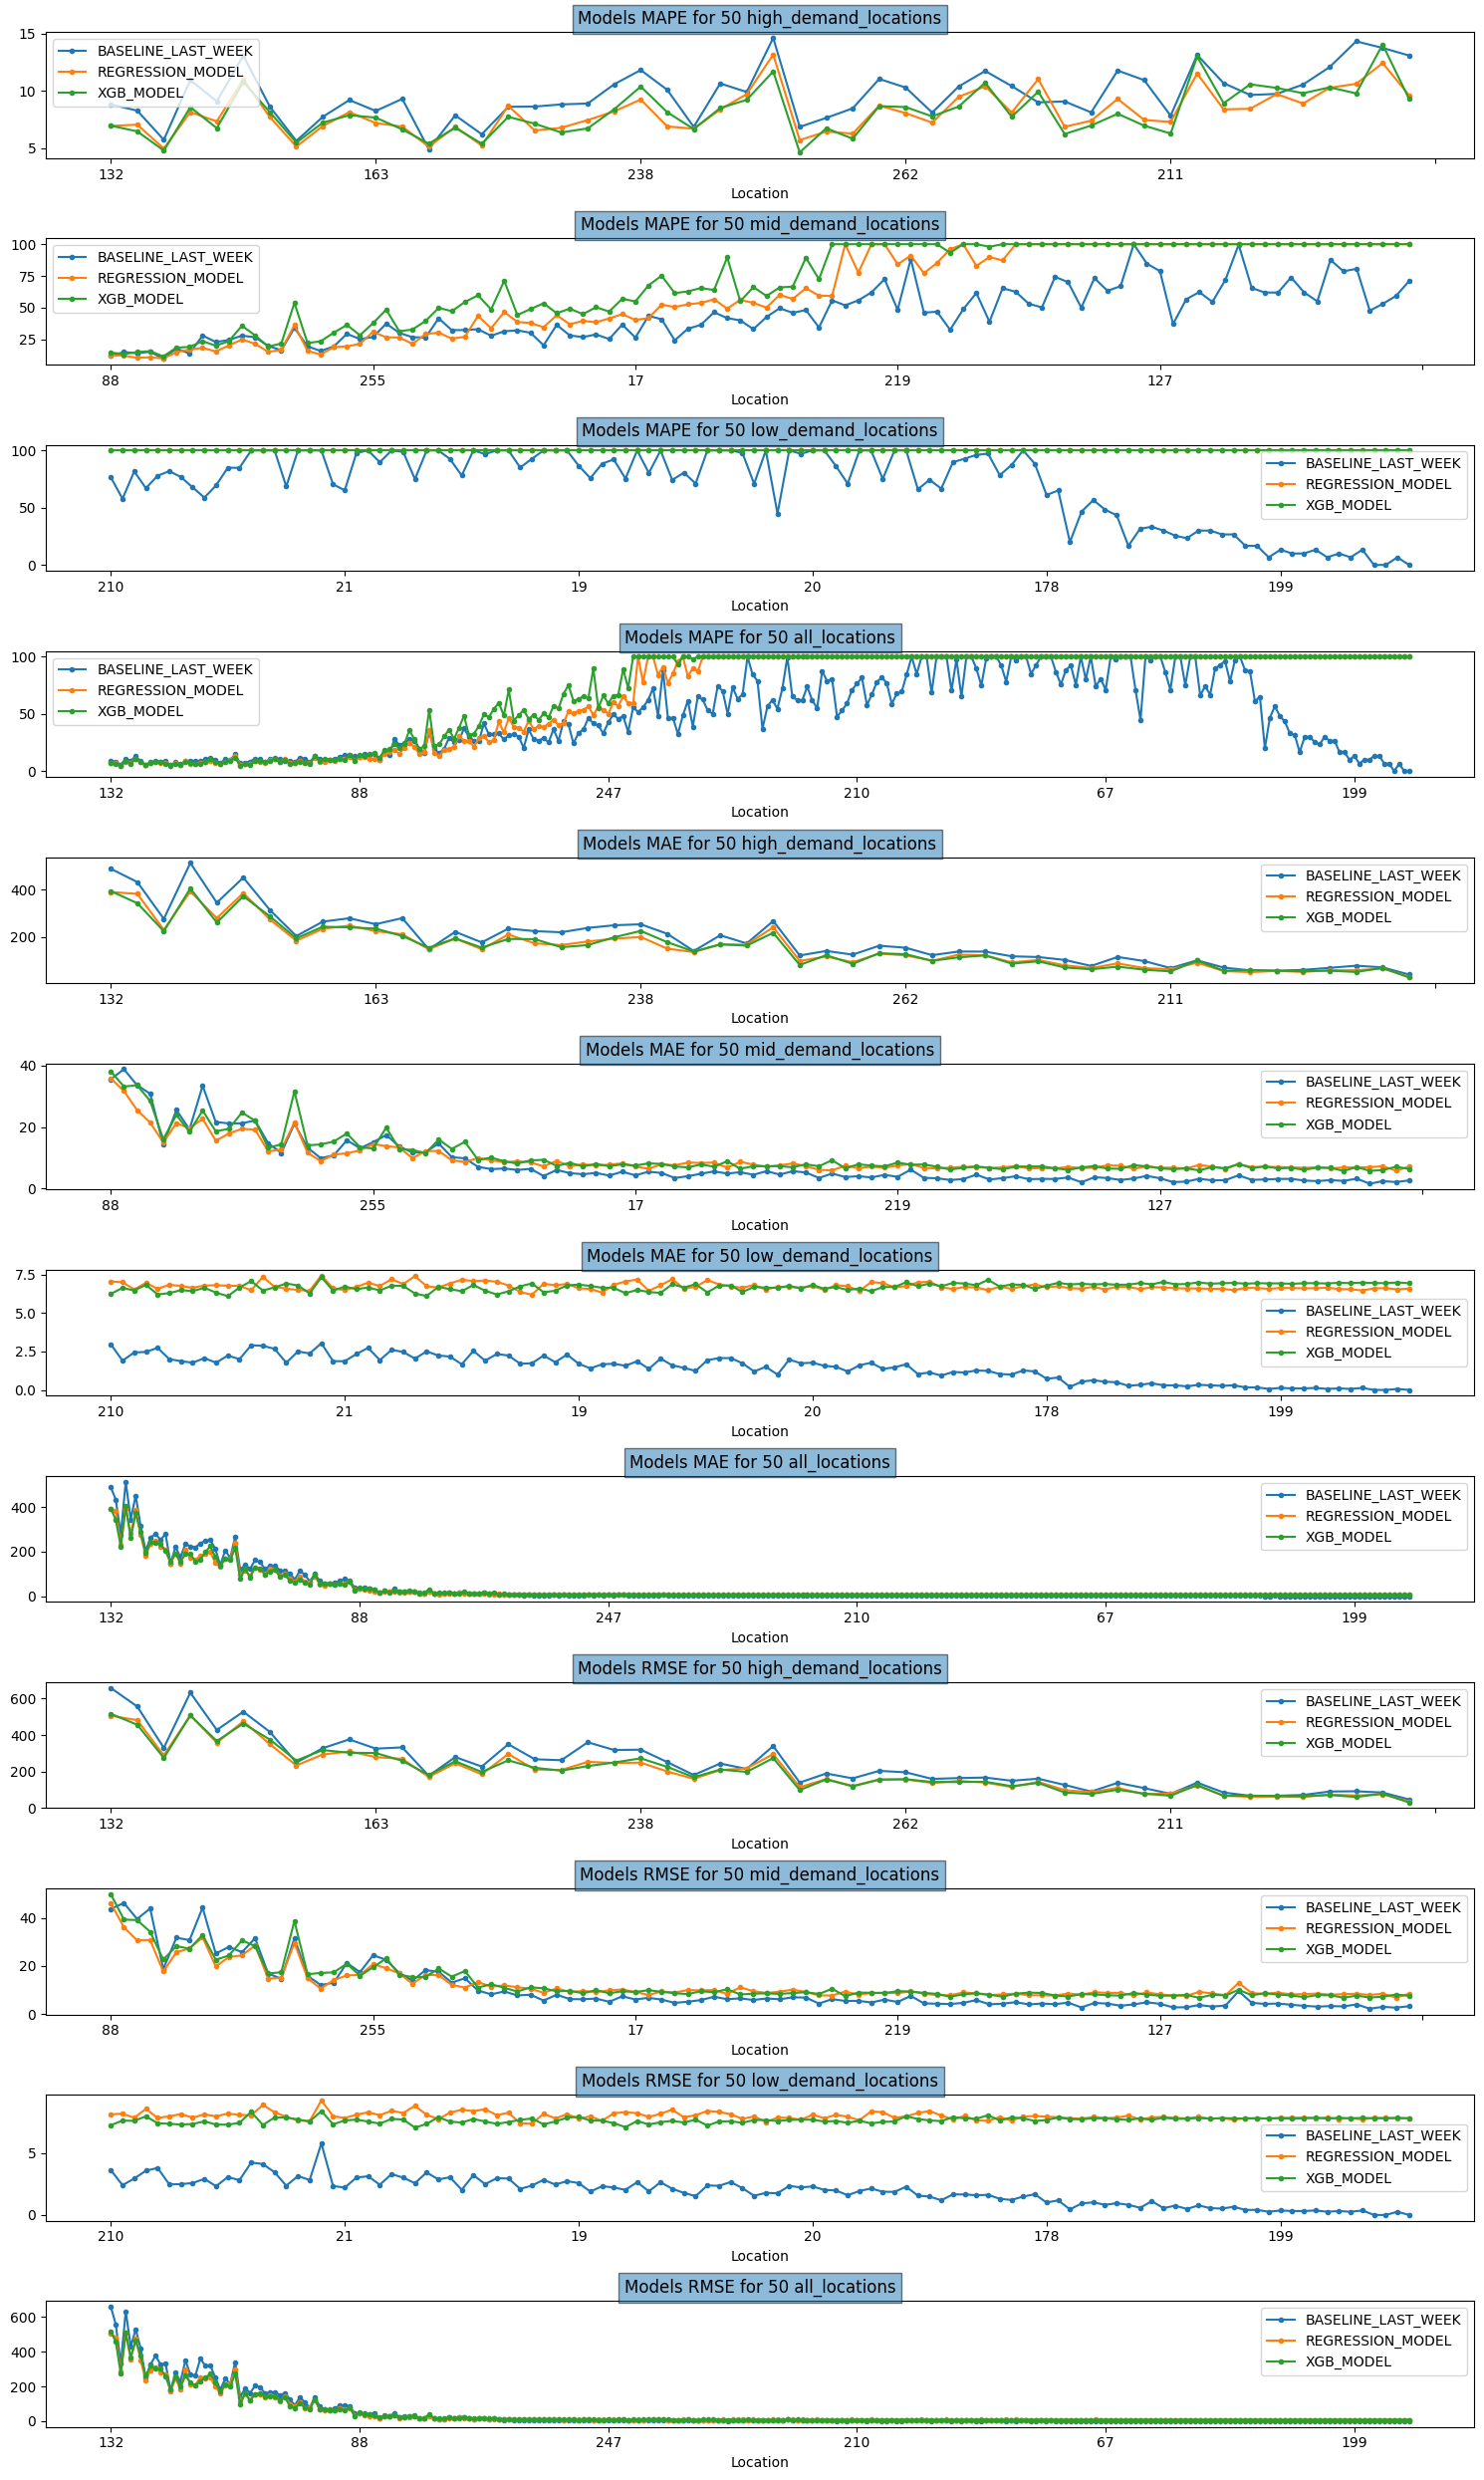

In [18]:
plot(predictions_mean_error_dict, 'Location')

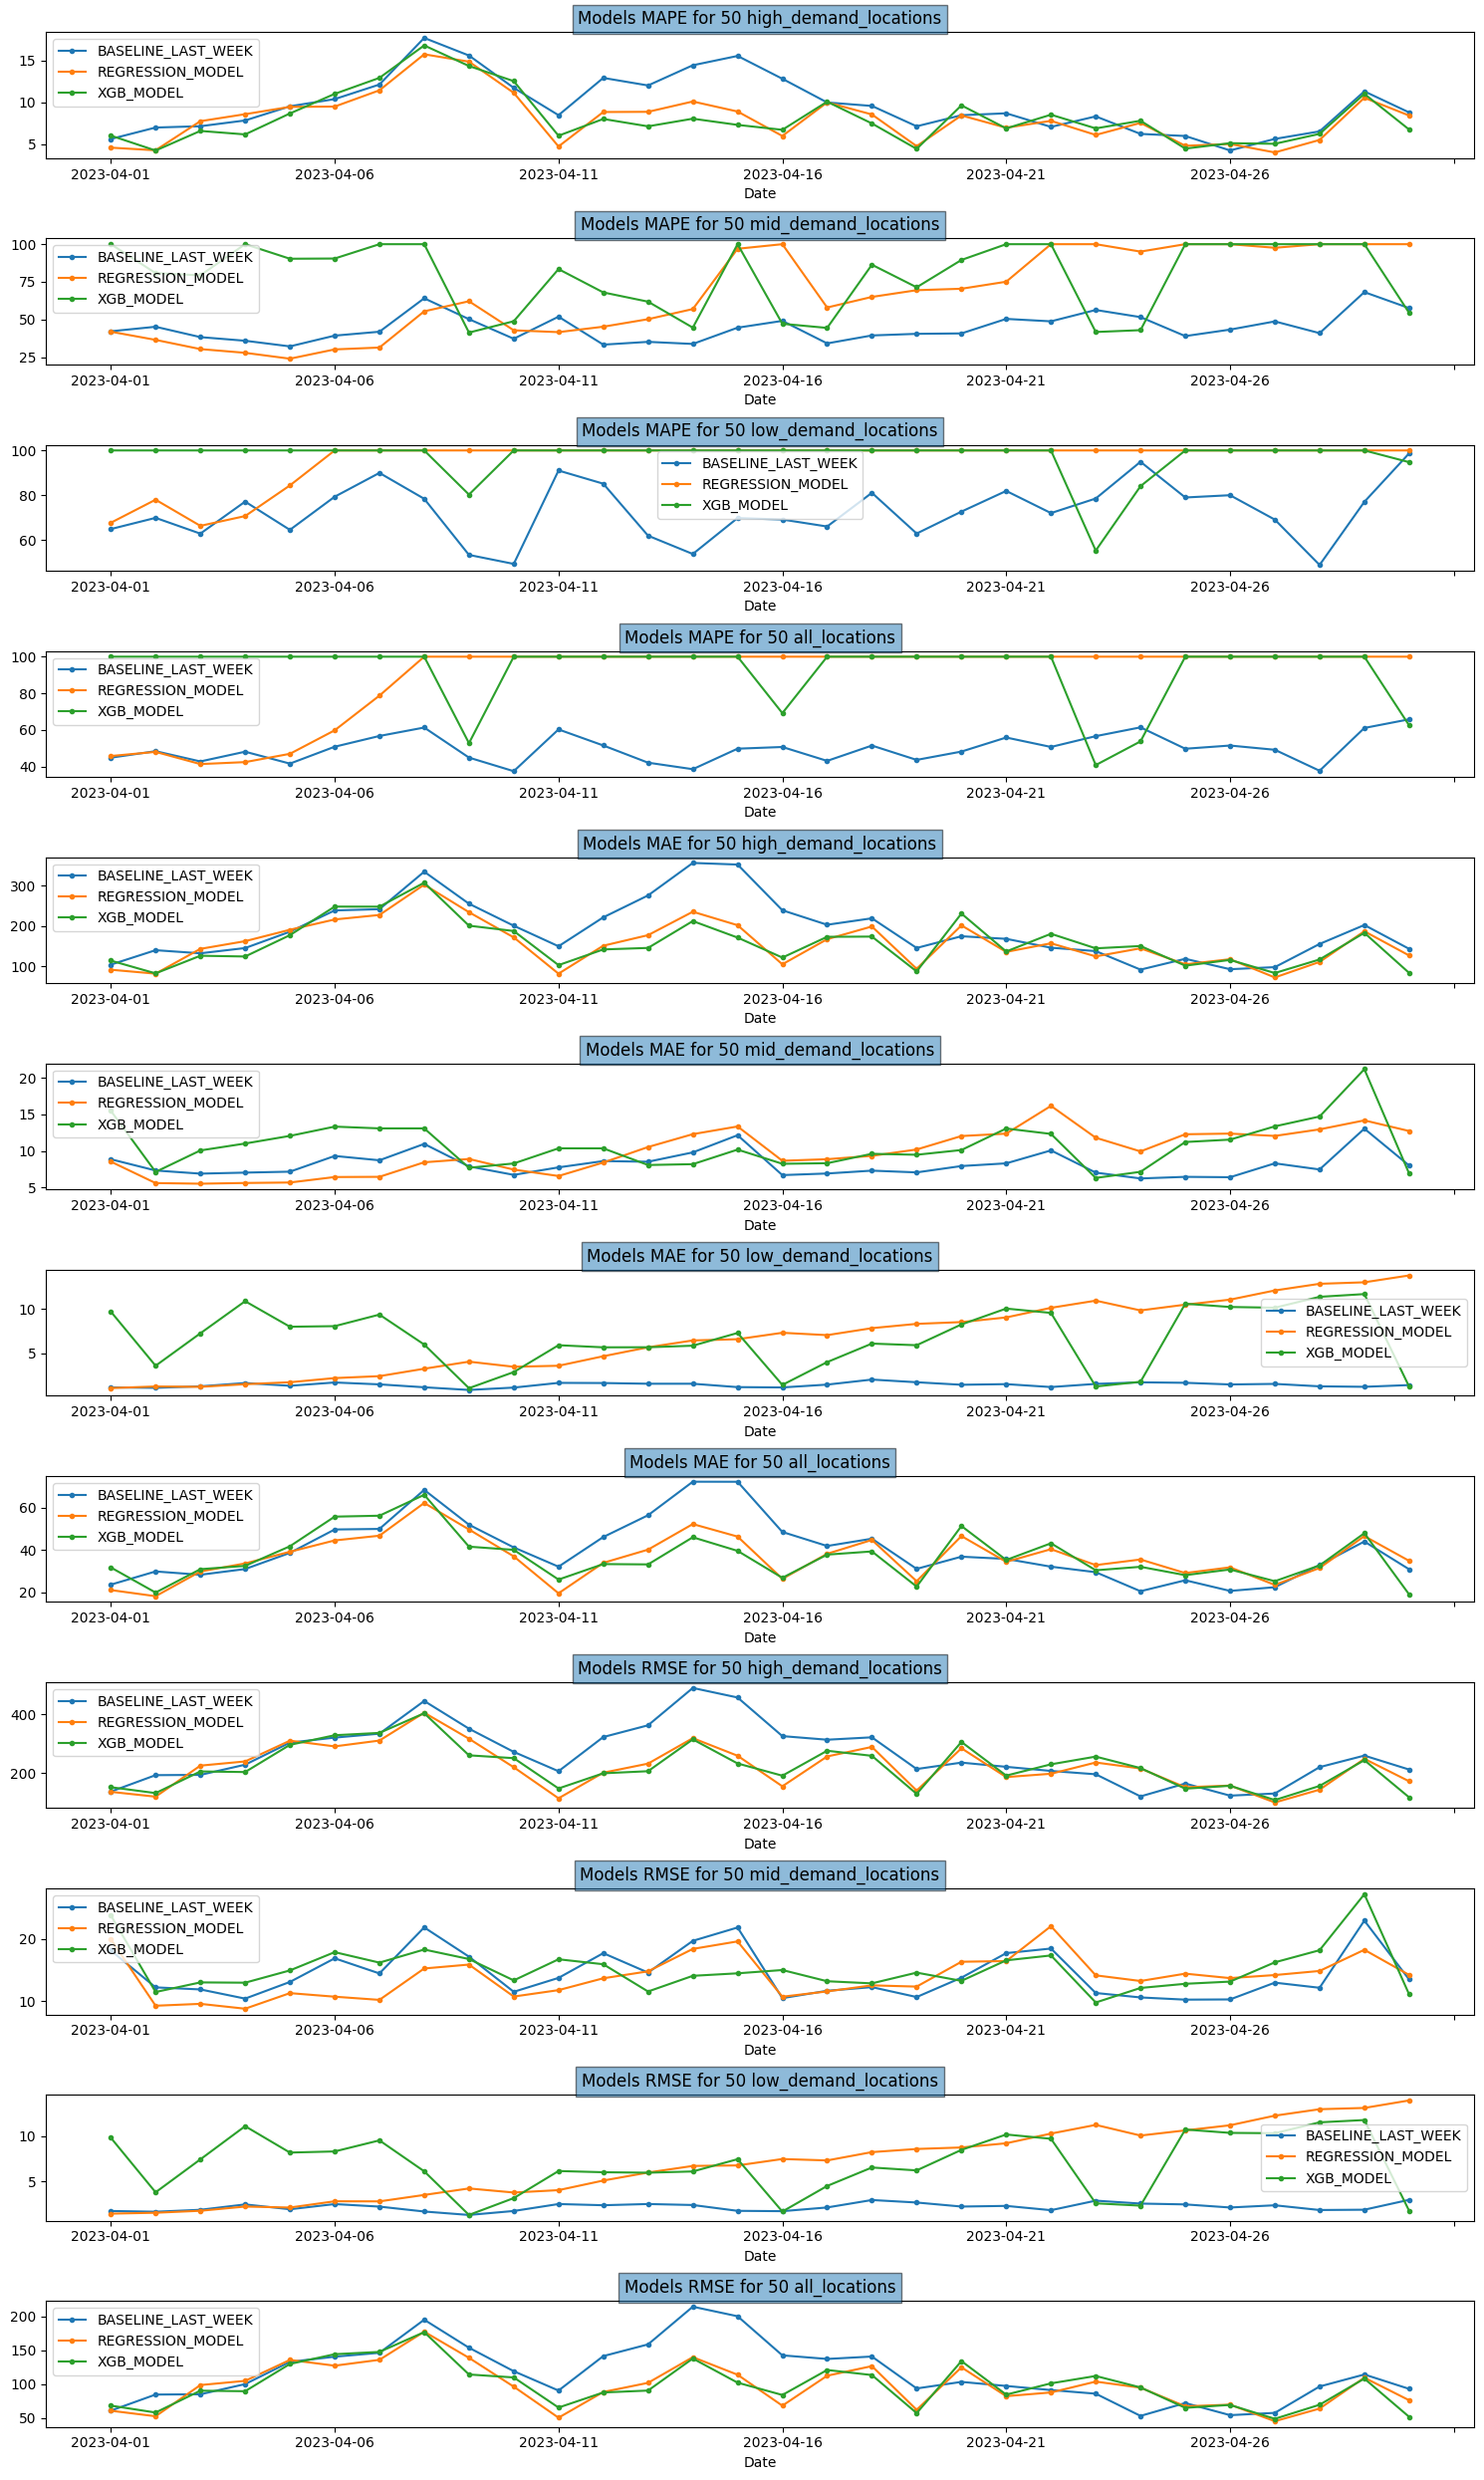

In [19]:
plot(predictions_mean_error_dict, 'Date')

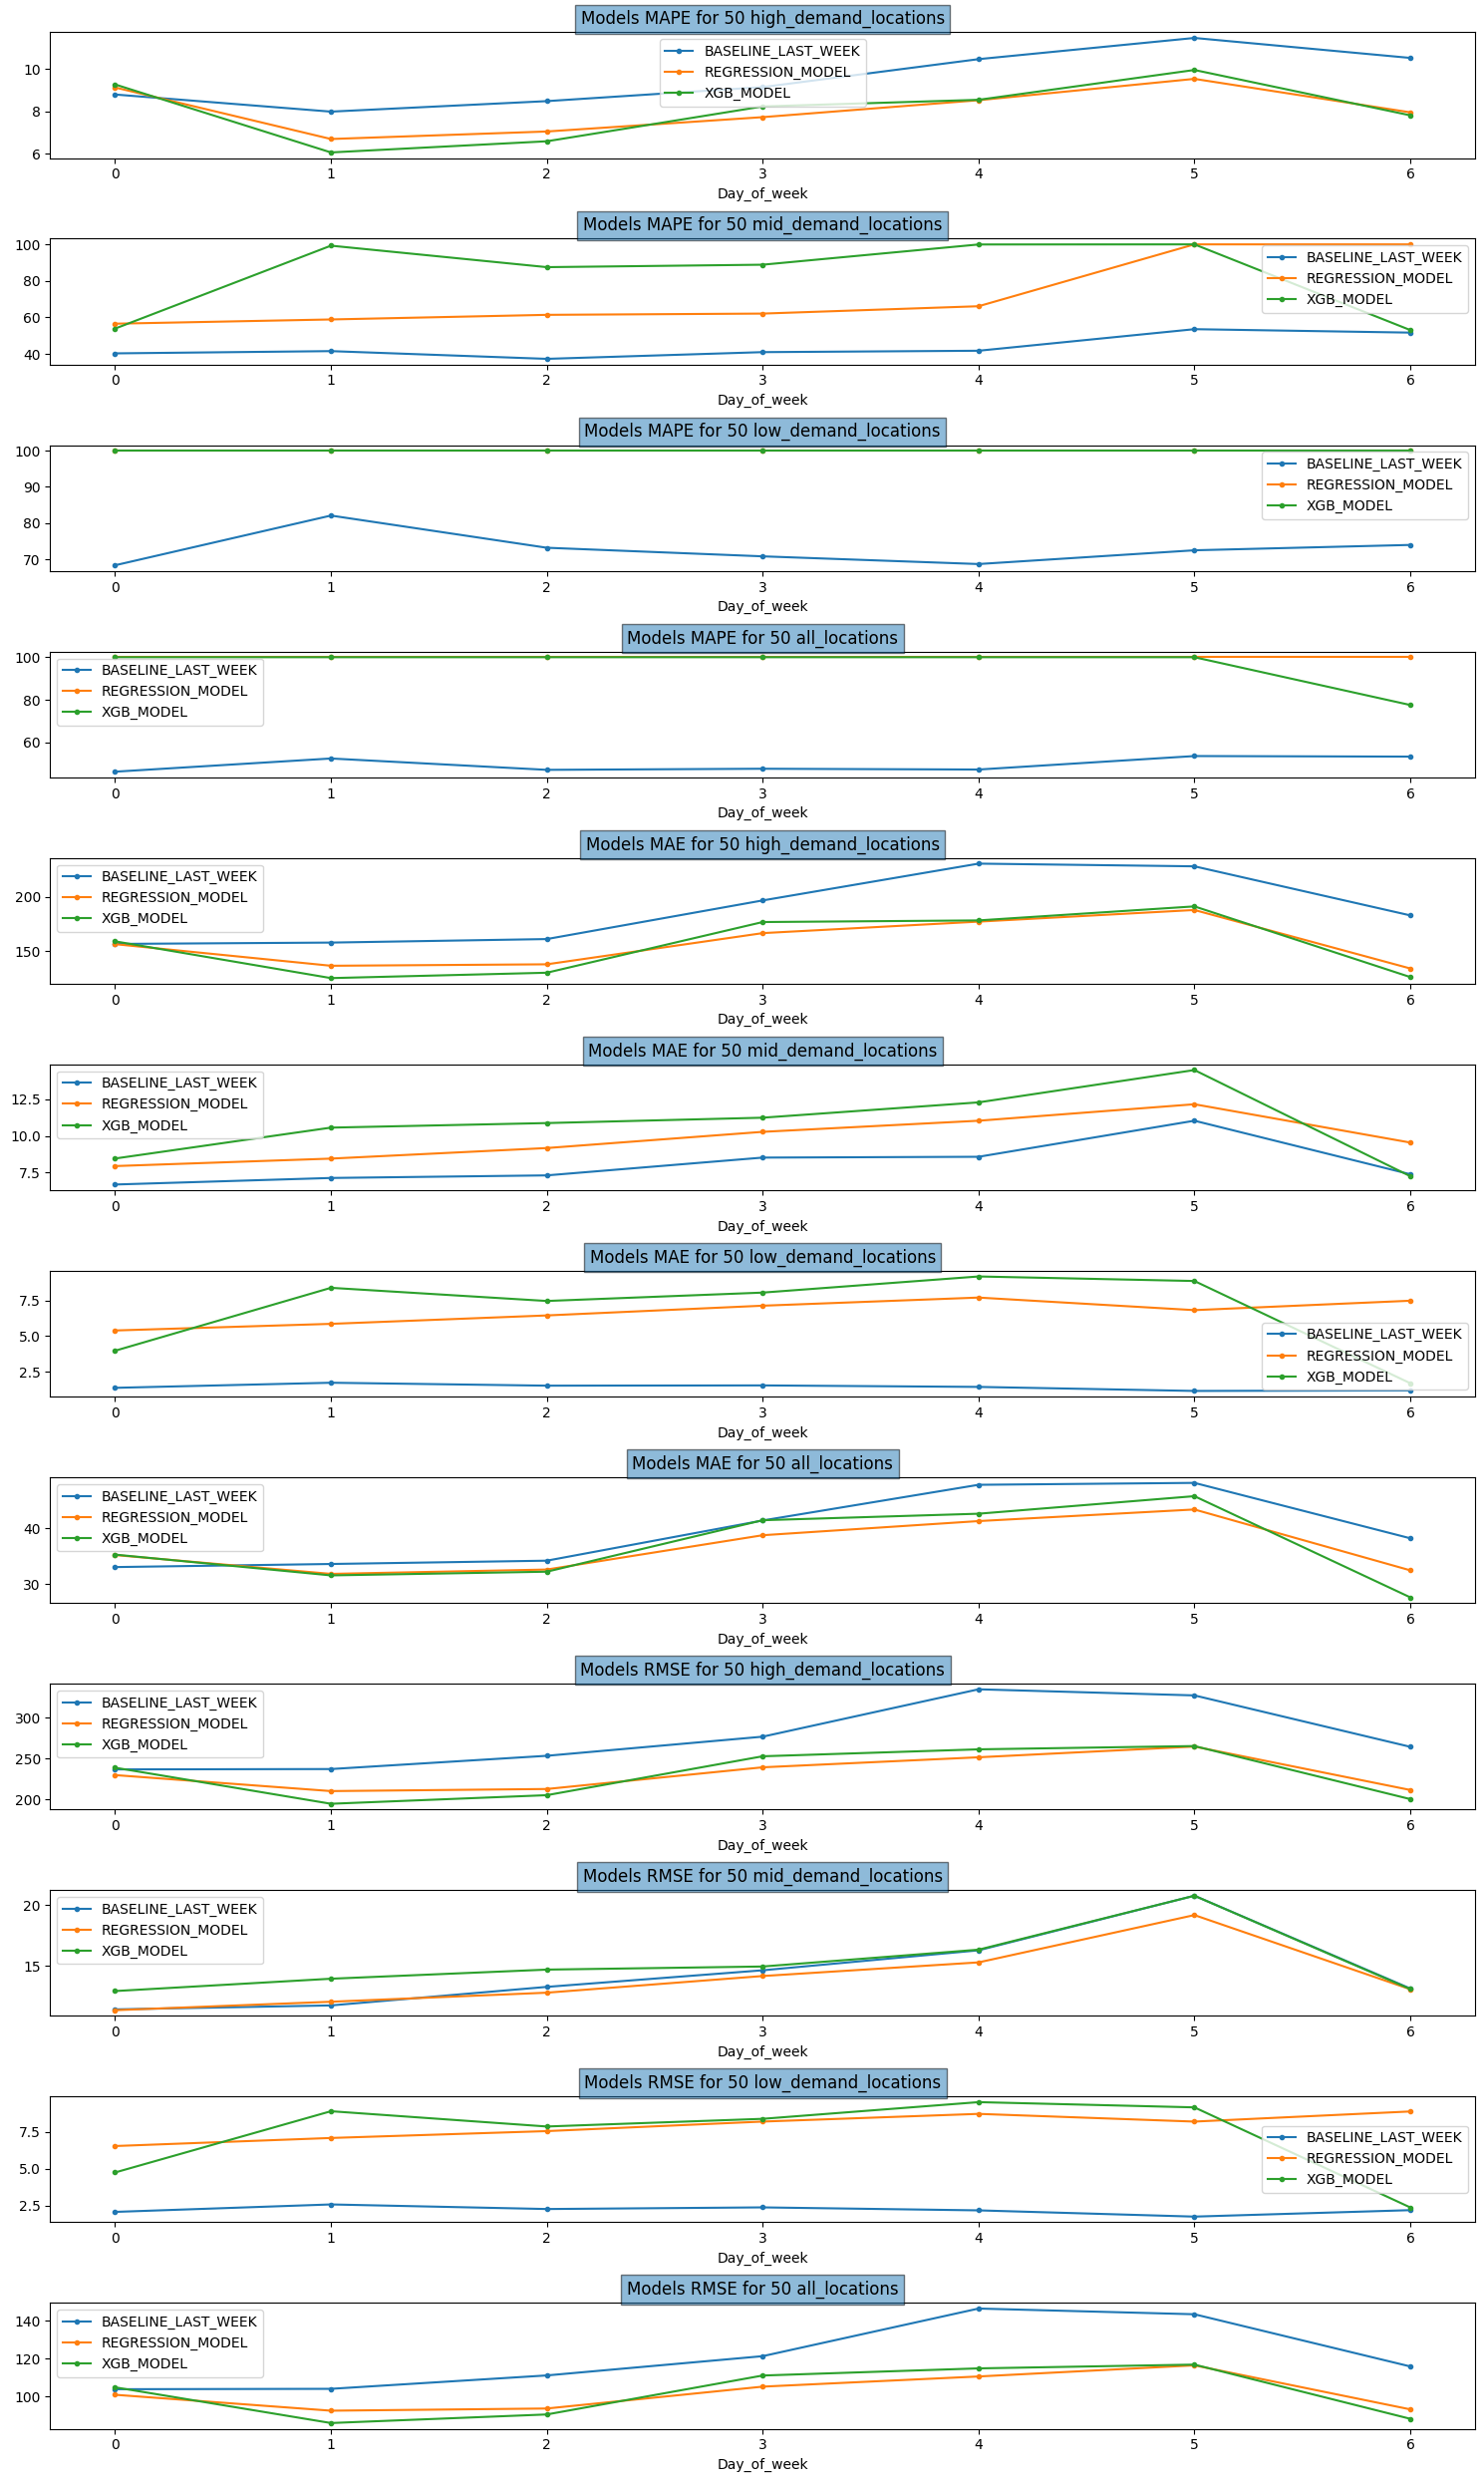

In [20]:
plot(predictions_mean_error_dict, 'Day_of_week')

# Table of Results

In [21]:
def create_table_errors(predictions_dict, report_dict):
    for model, error_df in predictions_dict.items():
        for cat in CATEGORIES:
            if error_df is not None:
                sorted_index = sorted_locations_dict[cat][['Location']]
                categorized_df = error_df.merge(sorted_index, on=['Location'])
                
                report_dict[cat]['MAE'][model] = categorized_df['error'].mean()            
                report_dict[cat]['RMSE'][model] = np.sqrt(categorized_df['squared_error'].mean())
                report_dict[cat]['MAPE'][model] = categorized_df['percentage_error'].mean()

    return report_dict

In [22]:
report_dict = create_table_errors(predictions_dict, report_dict)
report_df = pd.DataFrame.from_dict({(i,j): report_dict[i][j] 
                            for i in report_dict.keys() 
                            for j in report_dict[i].keys()},
                            orient='index')

report_df.index = pd.MultiIndex.from_tuples(report_df.index)
report_df = report_df.T

In [23]:
df = pd.DataFrame(report_df,
                  index=pd.Index(MODEL_LIST),
                  columns=pd.MultiIndex.from_product([CATEGORIES,
                                                      METRICS], names=['location CATEGORIES:', 'Error Metrics:']))


In [24]:
df.style.format('{:.2f}')